In [1]:
# Importing the libraries we'll be using for this project
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, RocCurveDisplay,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight


In [2]:
# load in database and split as neccessary
df = pd.read_csv('database_prev7days.csv')
df = df[df.Diff != 0]
print(df.shape)
# Splitting the training data into appropriate training and validation sets
X = df.drop(columns = ["Diff","date","Unnamed: 0"])
print(df.head(2))
y = df[['Diff']]
y = y.to_numpy().flatten()
weights = compute_class_weight(class_weight='balanced',classes = np.unique(y),y = y)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42,stratify=y)# makes sure train test splitting are the imbalanced by the same amount

(982, 67)
   Unnamed: 0      date  day7_pos_mean_likes  day7_pos_mean_replies  \
0           0  20170109             0.584927               0.552184   
1           1  20170110             4.102322               2.973540   

   day7_pos_mean_retweet  day7_neu_mean_likes  day7_neu_mean_replies  \
0               0.598106             2.431541               2.477603   
1               3.970256             4.156664               5.277351   

   day7_neu_mean_retweet  day7_neg_mean_likes  day7_neg_mean_replies  ...  \
0               2.434837             0.209339               0.196020  ...   
1               4.300867             0.074348               0.082443  ...   

   day1_pos_mean_replies  day1_pos_mean_retweet  day1_neu_mean_likes  \
0               3.828412               3.232838             8.028677   
1               6.260311               5.908047             6.780715   

   day1_neu_mean_replies  day1_neu_mean_retweet  day1_neg_mean_likes  \
0               8.366872              

In [3]:
def cv_fit_search(pipeline, param_grid, X_train,y_train,X_test,y_test,cv):
    """ a function to fit the data and do hyper parameter tuning
    Args:
        pipeline: a predefined pipeline
        param grid: a list of parameters that match the pipeline naming convetion
        CV: integer indicating the number of cross validations we want to do
        X_train:X to train on
        y_train: labels for Training Set
        X_test = held out data for final accuacry
        y_test = held out labels
    
    Return
    model: the fitted and hypertuned model,
    
    Prints: AUROC Curve, ACC AUC score of best models, best parameters found

    """
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, verbose=0,n_jobs=-1) # sets cross calidation settings
    grid_search.fit(X_train,y_train.ravel())

    pipeline_preds = grid_search.predict(X_test)
    val_accuracy = accuracy_score(y_test, pipeline_preds)
    val_roc_auc = roc_auc_score(y_test, pipeline_preds)
    f1 = f1_score(y_test, pipeline_preds)
    
    print("the best parametes are",grid_search.best_params_)
    print(f'Accuracy Score: {val_accuracy}')
    print(f'ROC AUC Score: {val_roc_auc}') 
    print(f'f1 Score: {f1}') 

    RocCurveDisplay.from_predictions(y_test, pipeline_preds)
    plt.show()
    return grid_search

the best parametes are {'model__criterion': 'entropy', 'model__max_depth': 40, 'model__min_samples_leaf': 6, 'model__min_samples_split': 6, 'model__n_estimators': 90}
Accuracy Score: 0.491869918699187
ROC AUC Score: 0.48447494669509594
f1 Score: 0.5487364620938627


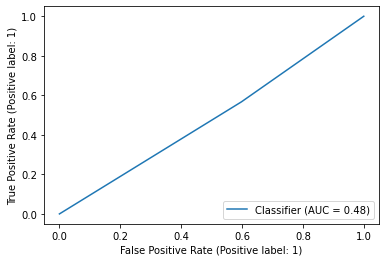

['model/randomforest_pipeline.pkl']

In [4]:
#Create a random forest pipeline
randomforest_pipeline = Pipeline(steps = [
    ('data_scaling', RobustScaler()),
    ('model', RandomForestClassifier(class_weight= "balanced"))
])
randomforest_param_grid = [
    {
        "model__n_estimators": np.arange(30,100,15),
        "model__criterion": ["gini","entropy"],
        "model__max_depth": np.arange(10,100,30),
        "model__min_samples_leaf": [3,6],
        "model__min_samples_split": [3,6]
        
    }
] 
tuned_model = cv_fit_search(randomforest_pipeline,randomforest_param_grid,X_train,y_train,X_val,y_val,10)
joblib.dump(tuned_model, 'model/randomforest_pipeline.pkl')

the best parametes are {'model__l2_regularization': 1, 'model__learning_rate': 0.01, 'model__loss': 'binary_crossentropy'}
Accuracy Score: 0.5365853658536586
ROC AUC Score: 0.5181902985074627
f1 Score: 0.6298701298701299


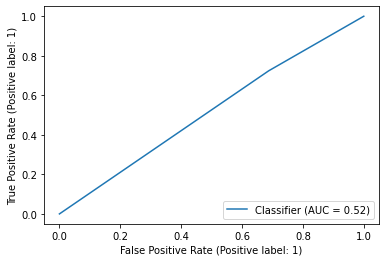

['model/boosting_pipeline.pkl']

In [5]:
# Lets try a boosting model now
# Due to the way boosting works, does not need weights to deal with imbalanced classes
from sklearn.ensemble import HistGradientBoostingClassifier
boostingPipeline = Pipeline(steps = [
    ('data_scaling', RobustScaler()),
    ('model', HistGradientBoostingClassifier())
])

boosting_param_grid = [
    {
        "model__loss": ["binary_crossentropy","auto"],
        "model__learning_rate": [0.01,0.05,0.1,0.5,1],
        "model__l2_regularization": [0,1]
    }
]   
tuned_model = cv_fit_search(boostingPipeline,boosting_param_grid,X_train,y_train,X_val,y_val,10)
joblib.dump(tuned_model, 'model/boosting_pipeline.pkl')

the best parametes are {'model__penalty': 'l1'}
Accuracy Score: 0.516260162601626
ROC AUC Score: 0.5141924307036247
f1 Score: 0.5475285171102662


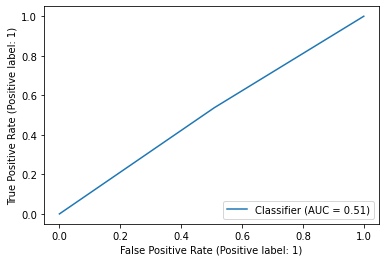

['model/lr_pipeline.pkl']

In [6]:
#logistic Regression with cross validation
from sklearn.linear_model import LogisticRegressionCV
lr_pipeline = Pipeline(steps = [
    ('data_scaling', RobustScaler()),
    ('model', LogisticRegressionCV(solver="liblinear",class_weight="balanced"))#saga solver works for all penalties
])

lr_param_grid = [
    {
        "model__penalty": ['l1', 'l2']
    }
]

tuned_model = cv_fit_search(lr_pipeline,lr_param_grid,X_train,y_train,X_val,y_val,10)
joblib.dump(tuned_model, 'model/lr_pipeline.pkl')

the best parametes are {'model__n_neighbors': 99}
Accuracy Score: 0.524390243902439
ROC AUC Score: 0.49013859275053306
f1 Score: 0.6666666666666667


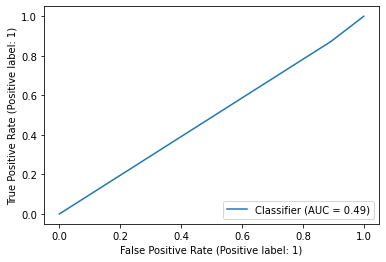

['model/knnc_pipeline.pkl']

In [7]:
#k nearest neighbors classifier
from sklearn.neighbors import KNeighborsClassifier

knnc_pipeline = Pipeline(steps = [
    ('data_scaling', RobustScaler()),
    ('model', KNeighborsClassifier())#10 cross validation
])

knnc_param_grid = [
    {
        "model__n_neighbors": np.arange(1,200)
    }
]

tuned_model = cv_fit_search(knnc_pipeline,knnc_param_grid,X_train,y_train,X_val,y_val,10)

joblib.dump(tuned_model, 'model/knnc_pipeline.pkl')


the best parametes are {'model__kernel': 'rbf'}
Accuracy Score: 0.556910569105691
ROC AUC Score: 0.5383128997867804
f1 Score: 0.6472491909385112


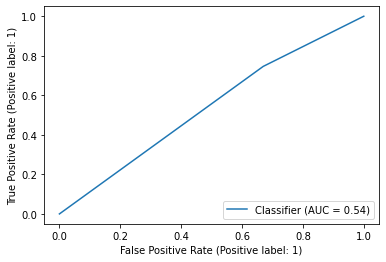

['model/svm_pipeline.pkl']

In [8]:
from sklearn.svm import SVC

svm_pipeline = Pipeline(steps = [
    ('data_scaling', RobustScaler()),
    ('model', SVC(class_weight="balanced"))#10 cross validation
])

svm_param_grid = [
    {
        "model__kernel": ['linear', 'poly', 'rbf']
    }
]

tuned_model = cv_fit_search(svm_pipeline,svm_param_grid,X_train,y_train,X_val,y_val,10)

joblib.dump(tuned_model, 'model/svm_pipeline.pkl')